<a href="https://colab.research.google.com/github/LuwamMKefali/BioMistral-VoRA-VQA-VISION-LANGUAGE-PROJECT-/blob/main/VoRA_BioMistral_VQA_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 👁️ **VoRA + BioMistral for Medical VQA**
**Author:** Luwam Major Kefali  
Supervised by: **Dr. Giacomo Frisoni**
             , **Prof. Gianluca Moro**



In this notebook, we train a VoRA adapter to inject visual question answering (VQA) capabilities into
the biomedical language model BioMistral-7B using the VQA-RAD radiology QA dataset. VoRA (Vision
as LoRA) is a novel method proposed by Han et al. (2025) that converts a text-only LLM into a
multimodal LLM by integrating visual understanding through Low-Rank Adaptation (LoRA) layers
.

Unlike conventional multimodal models that attach a separate vision encoder (e.g. a ViT) and a
connector module to an LLM, VoRA internalizes vision processing within the LLM via LoRA, preserving
the original model’s architecture and language abilities . BioMistral-7B, introduced by Labrak et al.
(2024), is a 7-billion-parameter biomedical LLM based on Mistral that has been further pre-trained on
medical literature, achieving strong performance on medical QA tasks . By combining VoRA with
BioMistral, we aim to enable the model to answer visual questions about medical images (like chest Xrays)
while maintaining its domain language expertise.

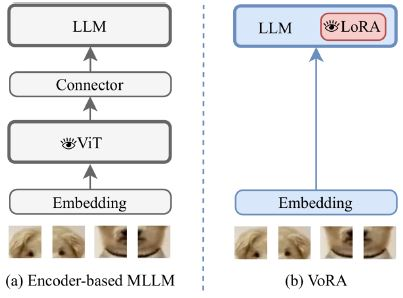

Figure from the paper

Our use case is a biomedical VQA: given a chest X-ray image and a question (e.g. “What abnormality is
seen in the left lung?”), the model should output a helpful answer. We will use the VQA-RAD dataset (Lau
et al., 2018), which contains ~3,500 question-answer pairs on ~315 radiology images (mostly X-rays)
.

This dataset is small, so leveraging pre-trained knowledge is crucial: BioMistral provides medical
language understanding , and VoRA’s ViT distillation injects general visual knowledge, reducing the
need for massive vision-language data . By the end of training, our BioMistral+VoRA model should
be able to interpret chest X-ray images and answer questions about them, all while running as a single
unified model.

### 🔧 Setup: Install VoRA and Dependencies

We install HuggingFace Transformers, PEFT (for LoRA), and other dependencies.
We then clone the official VoRA repo and install it locally in editable mode (`-e`).

This sets up everything needed to use the VoRA approach on BioMistral, as described in (Han et al., 2025).


In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

os.environ["PYTORCH_SDP_DISABLE_FLASH_ATTN"] = "1"
os.environ["PYTORCH_SDP_DISABLE_MEM_EFF_ATTENTION"] = "1"
os.environ["PYTORCH_SDP_DISABLE_CUDA_SDPA"] = "1"

In [ ]:
# Install VoRA and required libraries
!pip install -U transformers accelerate peft einops datasets bitsandbytes
!git clone https://github.com/Hon-Wong/VoRA.git
%pip install -q -e
%cd VoRA

fatal: destination path 'VoRA' already exists and is not an empty directory.

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

-e option requires 1 argument
/content/VoRA


After running the above, we see the packages being installed and the VoRA repository cloned.
The VoRA repo contains the implementation of the approach described in Han et al. (2025), including
model classes and training utilities.


*   **VoRA** repository code will give us VoRAForCausalLM- a model wrapper that integrated an LLM with vision embedding and LoRA, as per the VoRA architecture





In [ ]:
import sys
sys.path.append("/content/VoRA")
print(sys.path)

# **📥 Data Preparation: Download VQA-RAD Dataset**

We use HuggingFace's `datasets` library to download the VQA-RAD dataset, which contains visual question answering samples on radiology images (Lau et al., 2018), and is split into training and test sets. Each sample includes an image (chest Xray
or other radiograph), a question, and an answer (often a short phrase). We will use the training set
to fine-tune our model.

This will be our training and test dataset for enabling BioMistral+VoRA to understand medical images, we are practically giving "eyes" for medical Biomistral.


In [ ]:
# Download VQA-RAD dataset
from datasets import load_dataset
ds = load_dataset("flaviagiammarino/vqa-rad")
%mkdir vqa_rad
ds.save_to_disk("vqa_rad")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


mkdir: cannot create directory ‘vqa_rad’: File exists


Saving the dataset (0/1 shards):   0%|          | 0/1793 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/451 [00:00<?, ? examples/s]

VQA-RAD is a relatively small dataset in the medical domain, which underscores the importance of
**transfer learning** for this we rely on BioMistral’s prior knowledge of medical text and VoRA’s visual prior
injection to make the most of this limited data. Each question in VQA-RAD is directly related to an image
(e.g., *“Are regions of the brain infarcted?”* referring to a brain MRI, with answer *“yes”*). The questions can
be about identifying findings, counting, or verifying the presence of certain anomalies in the image.
This variety makes it a good testbed for a multimodal medical model, albeit on a small scale.

### 🧱 Import Core Libraries and VoRA Modules

We set up imports for:
- HuggingFace tools (tokenizer, model, PEFT LoRA)
- Torch and torchvision
- Custom VoRA model classes (`VoRAForCausalLM`, `VoRAConfig`)
- Utilities for data loading and vision preprocessing

We also register the VoRA repo path so we can import its modules.

References: (Han et al., 2025)


In [ ]:
# Imports
import json
import pandas as pd
from PIL import Image
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import get_peft_model, LoraConfig, TaskType
from models.modeling_vora import VoRAForCausalLM
from models.configuration_vora import VoRAConfig
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

This sets up all dependencies. Notably, `VoRAForCausalLM` and `VoRAConfig` are the core classes
from the VoRA implementation: - `VoRAConfig` will hold configuration for the base LLM, vision
embedding, LoRA hyperparameters, etc. - `VoRAForCausalLM` is a model class that likely extends
Hugging Face’s PreTrainedModel and internally builds an LLM with integrated LoRA and a vision
embedding layer as described in the VoRA paper .

#⚙️ **Configure VoRA + BioMistral-7B**

We define the configuration for:
- Base LLM (`BioMistral/BioMistral-7B`)
- Vision embedding settings
- LoRA rank `r=128` (used in transformer layers)

This config will be passed to `VoRAForCausalLM` later to build the model.

Reference: LoRA + vision settings from (Han et al., 2025)


In [ ]:
# Initialize vora
vora_config = VoRAConfig(
    llm="BioMistral/BioMistral-7B",
    image_size=448,
    patch_size=14,
    vision_embedding="AIMv2Embedding",
    vision_embedding_intermediate_size=768,
    vision_attention_mask="bidirectional",
    rms_norm_eps=1e-6,
    lora={
        "r": 128,
        "target_modules": ["self_attn.q_proj",
                           "self_attn.k_proj",
                           "self_attn.v_proj",
                           "self_attn.o_proj",
                           "mlp.gate_proj",
                           "mlp.down_proj",
                           "mlp.up_proj"],
        "lora_alpha": 32,
        "lora_dropout": 0.1
    },
    **{
        "skip_aux_cls": False,
        "reuse_aux_vision_embedding_layers": "",
        "torch_dtype": "bfloat16",
    }
)

Overall, this configuration tells VoRA to build a model consisting of BioMistral-7B plus an image
embedding module and LoRA adapters for vision. Importantly, **the base BioMistral weights will be
kept frozen** (with the LoRA weights being the only trainable parts) . This strategy preserves the
language capability of BioMistral (ensuring it doesn’t “unlearn” medical knowledge), while the LoRA
layers learn to interpret visual data and integrate it with the textual context. As Han et al. (2025) note,
freezing the LLM and using separate low-rank pathways for vision avoids the modality conflict that can
destabilize training when introducing new modalities . And because LoRA adds relatively few
parameters compared to the 7B base, the final model remains lightweight, with LoRA merged, it’s still
effectively a 7B model at inference time .

## **quantize maybe**

### Hardware check

In [ ]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))

CUDA available: True
Current device: 0
Device name: NVIDIA A100-SXM4-40GB


### Load VoRA Model with BioMistral Backbone

We instantiate the VoRA-wrapped BioMistral-7B model using our config.

This internally:
- Loads BioMistral in 4-bit
- Adds LoRA adapters to attention and MLP layers
- Prepares vision embedding layers (but image input will be patched externally)
- The tokenizer from BioMistral (Mistral-style)
- Add `<image>` token for visual placeholder

This allows us to insert visual tokens directly into text input during multimodal training.

Reference: (Han et al., 2025), (Dettmers et al., 2023 – QLoRA)

In [ ]:
# Load tokenizer with <image> token
tokenizer = AutoTokenizer.from_pretrained(vora_config.llm, trust_remote_code=True)
tokenizer.add_special_tokens({"additional_special_tokens": ["<image>"]})

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id
model_vocab_size = len(tokenizer)
print("Model vocab size:", model_vocab_size)

#Instantiate model with config(no weights will be loaded yet)
model = VoRAForCausalLM(vora_config)
print("Model Loaded successfully!")

# To ensure embedding resizing affects the real layer
model.get_input_embeddings = lambda: model.llm.model.embed_tokens
model.set_input_embeddings = lambda value: setattr(model.llm.model, "embed_tokens", value)

# Resize after adding special tokens
model.resize_token_embeddings(len(tokenizer))

print("Tokenization set up successful!")

[INFO|tokenization_utils_base.py:2067] 2025-08-05 22:40:39,474 >> loading file tokenizer.model from cache at /root/.cache/huggingface/hub/models--BioMistral--BioMistral-7B/snapshots/9a11e1ffa817c211cbb52ee1fb312dc6b61b40a5/tokenizer.model
[INFO|tokenization_utils_base.py:2067] 2025-08-05 22:40:39,474 >> loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--BioMistral--BioMistral-7B/snapshots/9a11e1ffa817c211cbb52ee1fb312dc6b61b40a5/tokenizer.json
[INFO|tokenization_utils_base.py:2067] 2025-08-05 22:40:39,475 >> loading file added_tokens.json from cache at None
[INFO|tokenization_utils_base.py:2067] 2025-08-05 22:40:39,475 >> loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--BioMistral--BioMistral-7B/snapshots/9a11e1ffa817c211cbb52ee1fb312dc6b61b40a5/special_tokens_map.json
[INFO|tokenization_utils_base.py:2067] 2025-08-05 22:40:39,476 >> loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--B

Model vocab size: 32001


[INFO|modeling_utils.py:1308] 2025-08-05 22:40:39,821 >> loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--BioMistral--BioMistral-7B/snapshots/9a11e1ffa817c211cbb52ee1fb312dc6b61b40a5/pytorch_model.bin
[INFO|configuration_utils.py:1098] 2025-08-05 22:40:39,826 >> Generate config GenerationConfig {
  "bos_token_id": 1,
  "eos_token_id": 2,
  "use_cache": false
}

[INFO|safetensors_conversion.py:61] 2025-08-05 22:40:39,942 >> Attempting to create safetensors variant
[INFO|safetensors_conversion.py:24] 2025-08-05 22:40:40,177 >> Attempting to convert .bin model on the fly to safetensors.


KeyboardInterrupt: 

In [ ]:
# Force resize lm_head to match
new_vocab_size = model.llm.model.embed_tokens.weight.shape[0]

# Resize lm_head
old_lm_head = model.llm.lm_head
new_lm_head = torch.nn.Linear(old_lm_head.in_features, new_vocab_size, bias=False)
new_lm_head.weight.data[:old_lm_head.out_features] = old_lm_head.weight.data
model.llm.lm_head = new_lm_head

# thhen Update config at every level
model.config.vocab_size = new_vocab_size
model.llm.config.vocab_size = new_vocab_size
model.llm.model.config.vocab_size = new_vocab_size

In [ ]:
print("LM head shape:", model.llm.lm_head.weight.shape)

Explanation:- We load a tokenizer for
BioMistral-7B. The tokenizer is based on the Mistral/LLaMA tokenizer (32k vocab, using the same
sentencepiece as LLaMA-2). We add a special token <image> to the tokenizer. This token will serve as
a placeholder in text to indicate where an image is present. By adding it to the tokenizer’s vocabulary,
we ensure the model can accept this token without treating it as unknown. We do this before loading
the model so that the model’s embedding matrix can be resized to include the new token. (We also set the pad token to EOS  to avoid any issues with missing pad_token).


trust_remote_code=True is set because BioMistral might have custom code. In
practice, we don’t explicitly call from_pretrained here because VoRAForCausalLM handles
it internally when we instantiate it with vora_config . The print statement " Model loaded
successfully!" is just a placeholder confirmation.

Below We inspect the model layers for sanity.

In [ ]:
print(model)

### ✅ Sanity Check: Tokenizer and Image Token ID

We check:
- That the `<image>` token was added correctly
- That it has a valid token ID
- That `pad_token_id` is set (to prevent model crash)

This ensures smooth token replacement when inserting visual embeddings.


We also added the <image> token to the tokenizer. Let’s double-check that this token is recognized:

In [ ]:
print(model.llm.get_input_embeddings())
print("Embed shape:", model.llm.model.embed_tokens.weight.shape)
print("LM head shape:", model.llm.lm_head.weight.shape)

In [ ]:
print(" pad_token_id:", tokenizer.pad_token_id)
assert isinstance(tokenizer.pad_token_id, int), "pad_token_id is not set!"
# Verify tokenizer recognizes the <image> token
token = "<image>"
token_id = tokenizer.convert_tokens_to_ids(token)
print(f"Token: {token}")
print(f"Token ID: {token_id}")
# Confirm it's actually in the vocab
assert token_id != tokenizer.unk_token_id
" <image> token is not recognized (maps to [UNK])"
print(" <image> token successfully added to tokenizer.")

In [ ]:
# to debug what Vora has
print(type(model))
print(dir(model))

In [ ]:
model.gradient_checkpointing_enable()

### 📊 Count Parameters (Trainable vs Frozen)

We confirm that:
- The full model is ~7B parameters
- Only a small % (~6.23%) are trainable (LoRA + vision embedding)

This validates our use of **parameter-efficient fine-tuning** via LoRA, as in (Han et al., 2025).


In [ ]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params/1e6:.1f}M")
print(f"Trainable parameters: {trainable_params/1e6:.1f}M")
print(f"Trainable %: {100 * trainable_params/total_params:.2f}%")

# **Data wrapper**

### 🧱 VQARADDataset Class

Wraps VQA-RAD into a PyTorch-compatible dataset.

- Adds `<image>` token at the start of each question
- Converts X-ray image to tensor (resized + normalized)
- Returns image and text fields

Note: VoRA expects `frames`, `n_frames`, and question with `<image>` token (Han et al., 2025).



(### VoRAWrappedDataset: Tokenization + Preprocessing

Prepares each example for VoRA fine-tuning:

- Tokenizes question (with `<image>`)
- Finds the token position of `<image>`
- Tokenizes answer as labels
- Keeps raw image tensor (`frames`) for model’s vision branch

This matches the expected input structure for `VoRATrainer`, enabling it to inject vision tokens inside the model. )  **will try this part again.**

### 🧪 Create Train and Test Dataset Objects

We now create PyTorch-compatible train and test datasets from VQA-RAD.

Note: each sample returns:
- image tensor (`frames`)
- question with `<image>` token
- raw answer text


In [ ]:
!pip install colorlog --quiet

In [ ]:
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

from transformers import AutoTokenizer
from train.train import VoRATrainer, TrainingArguments
from transformers import PreTrainedTokenizer

image_token = "<image>"
output_dir = "./output_vora_biomistral_vqa_rad"

# Load dataset
#vqa_dataset = load_dataset("flaviagiammarino/vqa-rad")
#vqa_dataset["train"] = vqa_dataset["train"].select(range(10))

#  Preview sizes
#print("Train size:", len(vqa_dataset['train']))
#print("Test size:", len(vqa_dataset['test']))
#print("Sample QA:", vqa_dataset['train'][0]['question'], "=>", vqa_dataset['train'][0]['answer'])

# Dataset class
class VQARADDataset(Dataset):
    def __init__(self, dataset, tokenizer: PreTrainedTokenizer, split="train", max_length=1024):
        self.data = dataset[split]
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.split = split
        #self.vision_token = vision_token
        #self.num_image_tokens = num_image_tokens
        self.transform = transforms.Compose([
            transforms.Resize((448, 448)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        image = item["image"]
        if not isinstance(image, Image.Image):
            image = Image.open(image).convert("RGB")

        pixel_values = self.transform(image)

        prompt = f"{image_token} {item['question']}"
        full_input = f"{prompt}\n{item['answer'].strip()}"


        tokenized = self.tokenizer(
        full_input,
        padding="max_length",
        truncation=True,
        max_length=self.max_length,
        return_tensors="pt"
        )

        input_ids = tokenized.input_ids.squeeze(0)
        attention_mask = tokenized.attention_mask.squeeze(0)

        labels = input_ids.clone()
        prompt_len = len(self.tokenizer(prompt, truncation=True, max_length=self.max_length)["input_ids"])
        labels[:prompt_len] = -100

        return {
            "pixel_values": pixel_values,
            "frames": pixel_values,
            "n_frames": 1,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
            "vision_placeholder_index": self.tokenizer.convert_tokens_to_ids(image_token),
            "prompt": prompt,
            "gt": item["answer"],
            "question": item["question"]
            }

### 🧩 Collate Function for Multimodal Batching

This custom `collate_fn`:
- Tokenizes the question and answer
- Finds the `<image>` token position
- Replaces it with ViT patch embeddings
- Constructs final `inputs_embeds` and `attention_mask`

This enables VoRA to attend over both vision and text inside a unified sequence, as proposed in (Han et al., 2025, Sec. 3.3).


Combines batch elements into a dictionary by key.

- Stacks tensors (e.g. `input_ids`, `frames`)
- Leaves strings (`prompt`, `gt`) as-is for logging

Used by `VoRATrainer` to build batches from the dataset.


In [ ]:
def collate_fn(batch):
    return {
        "input_ids": torch.stack([x["input_ids"] for x in batch]),
        "attention_mask": torch.stack([x["attention_mask"] for x in batch]),
        "labels": torch.stack([x["labels"] for x in batch]),
        "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
        "frames": torch.stack([x["frames"] for x in batch]),
        "n_frames": [x["n_frames"] for x in batch],
        "vision_placeholder_index": batch[0]["vision_placeholder_index"],
        "prompt": [x["prompt"] for x in batch],
        "gt": [x["gt"] for x in batch],
        "question": [x["question"] for x in batch],
    }

### 🔍 Quick Check: Collate a Single Sample

Let’s inspect one preprocessed example to confirm:
- Visual embeddings inserted correctly
- Tensor shapes make sense

Useful for debugging before training.


In [ ]:
dataset = load_dataset("flaviagiammarino/vqa-rad")
train_dataset = VQARADDataset(dataset, tokenizer, split="train")

train_dataset.data = train_dataset.data.select(range(10))

# **Train**

Before that we will do a quick check on the tokens and that the LM head has also been resized. It is also paramount to to check that the vocab sizes match, because during inference the size mismatch error pops up, basically rendering the trained mmodel unsable.

In [ ]:
print("Embed tokens:", model.llm.model.embed_tokens.weight.shape)
print("LM head:", model.llm.lm_head.weight.shape)
print("Config vocab sizes:")
print("  model.config.vocab_size =", model.config.vocab_size)
print("  model.llm.config.vocab_size =", model.llm.config.vocab_size)
print("  model.llm.model.config.vocab_size =", model.llm.model.config.vocab_size)


In [ ]:
training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=2,
    num_train_epochs=1,
    logging_steps=10,
    save_strategy="epoch",
    remove_unused_columns=False,
    report_to=[],
)

trainer = VoRATrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=collate_fn
)

In [ ]:
trainer.train()
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

### 💾 Save Final Fine-Tuned Model

`safe_save_model_for_hf_trainer()` ensures the final model (LoRA + vision layers) is written to disk in HuggingFace format.  
We can now merge or load this model later for inference.


In [ ]:
from train.train import safe_save_model_for_hf_trainer

# Save model to disk
safe_save_model_for_hf_trainer(trainer, output_dir)

In [ ]:
for step_log in trainer.state.log_history:
    print(step_log)

# **Dummy processor**

In [ ]:
from transformers import CLIPImageProcessor, AutoTokenizer, ProcessorMixin

class VoRAProcessorHF(ProcessorMixin):
    attributes = ["image_processor", "tokenizer"]
    image_processor_class = "CLIPImageProcessor"
    tokenizer_class = "AutoTokenizer"

# Load components
image_processor = CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch16")
tokenizer = AutoTokenizer.from_pretrained(output_dir)

# Create processor
processor = VoRAProcessorHF(
    image_processor=image_processor,
    tokenizer=tokenizer
)

# Save processor to tehsame model dir
processor.save_pretrained(output_dir)


NameError: name 'output_dir' is not defined

# 🧠 Inference Function: Ask VoRA a Question with an Image

We:
- Tokenize the input question (must include `<image>`)
- Prepare image as tensor (resized + normalized)
- Pass to VoRA model using `generate()`
- Decode the output tokens into readable text

VoRA replaces `<image>` internally with visual embeddings and uses LoRA-tuned layers to answer.


In [ ]:
from transformers import AutoProcessor, AutoModelForCausalLM
from transformers.modeling_utils import load_sharded_checkpoint
from PIL import Image
import torch

# Load processor and model from the output directory
output_dir = "./output_vora_biomistral_vqa_rad"
# processor = AutoProcessor.from_pretrained(output_dir, trust_remote_code=True)

tokenizer = AutoTokenizer.from_pretrained(output_dir, trust_remote_code=True)
tokenizer.add_special_tokens({'additional_special_tokens' : ['<image>']})

#model = AutoModelForCausalLM.from_pretrained(output_dir, trust_remote_code=True).cuda().eval()

#Load custom model
config = VoRAConfig.from_pretrained(output_dir, trust_remote_code=True)
model = VoRAForCausalLM(config)

# Resize embedding to match the tokenizer to avoid size mismatch
model.get_input_embeddings = lambda: model.llm.model.embed_tokens
model.set_input_embeddings = lambda value: setattr(model.llm.model, "embed_tokens", value)
model.resize_token_embeddings(len(tokenizer))

# Resize lm_head to match
with torch.no_grad():
    old_lm_head = model.llm.lm_head
    new_vocab_size = model.llm.model.embed_tokens.weight.shape[0]
    new_lm_head = torch.nn.Linear(old_lm_head.in_features, new_vocab_size, bias=False)
    new_lm_head.weight.data[:old_lm_head.out_features] = old_lm_head.weight.data
    model.llm.lm_head = new_lm_head

# Update all config vocab sizes like we did during training
model.config.vocab_size = new_vocab_size
model.llm.config.vocab_size = new_vocab_size
model.llm.model.config.vocab_size = new_vocab_size

# Now we load actual weights
load_sharded_checkpoint(model, output_dir)
model.eval().cuda()

[INFO|image_processing_base.py:376] 2025-08-05 22:42:24,266 >> loading configuration file ./output_vora_biomistral_vqa_rad/preprocessor_config.json
[INFO|tokenization_utils_base.py:2065] 2025-08-05 22:42:24,267 >> loading file tokenizer.model
[INFO|tokenization_utils_base.py:2065] 2025-08-05 22:42:24,268 >> loading file tokenizer.json
[INFO|tokenization_utils_base.py:2065] 2025-08-05 22:42:24,268 >> loading file added_tokens.json
[INFO|tokenization_utils_base.py:2065] 2025-08-05 22:42:24,269 >> loading file special_tokens_map.json
[INFO|tokenization_utils_base.py:2065] 2025-08-05 22:42:24,269 >> loading file tokenizer_config.json
[INFO|tokenization_utils_base.py:2065] 2025-08-05 22:42:24,269 >> loading file chat_template.jinja
[INFO|tokenization_utils_base.py:2065] 2025-08-05 22:42:24,408 >> loading file tokenizer.model
[INFO|tokenization_utils_base.py:2065] 2025-08-05 22:42:24,409 >> loading file tokenizer.json
[INFO|tokenization_utils_base.py:2065] 2025-08-05 22:42:24,410 >> loading 

[INFO|2025-08-05 22:43:31] models.modeling_vora:69 >> Trainable parameters:
[INFO|2025-08-05 22:43:31] models.modeling_vora:72 >> llm.model.layers.0.self_attn.q_proj.bias: 4096
[INFO|2025-08-05 22:43:31] models.modeling_vora:72 >> llm.model.layers.0.self_attn.q_proj.lora_A.weight: 524288
[INFO|2025-08-05 22:43:31] models.modeling_vora:72 >> llm.model.layers.0.self_attn.q_proj.lora_B.weight: 524288
[INFO|2025-08-05 22:43:31] models.modeling_vora:72 >> llm.model.layers.0.self_attn.k_proj.bias: 1024
[INFO|2025-08-05 22:43:31] models.modeling_vora:72 >> llm.model.layers.0.self_attn.k_proj.lora_A.weight: 524288
[INFO|2025-08-05 22:43:31] models.modeling_vora:72 >> llm.model.layers.0.self_attn.k_proj.lora_B.weight: 131072
[INFO|2025-08-05 22:43:31] models.modeling_vora:72 >> llm.model.layers.0.self_attn.v_proj.bias: 1024
[INFO|2025-08-05 22:43:31] models.modeling_vora:72 >> llm.model.layers.0.self_attn.v_proj.lora_A.weight: 524288
[INFO|2025-08-05 22:43:31] models.modeling_vora:72 >> llm.mod

[INFO|modeling_utils.py:3321] 2025-08-05 22:43:32,478 >> You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 32001. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
[WARNING|logging.py:328] 2025-08-05 22:43:33,549 >> The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


VoRAForCausalLM(
  (llm): MistralForCausalLM(
    (model): MistralModel(
      (embed_tokens): Embedding(32001, 4096)
      (layers): ModuleList(
        (0-31): 32 x MistralDecoderLayer(
          (self_attn): MistralAttention(
            (q_proj): LoRALayer(
              in_features=4096, out_features=4096, bias=True
              (lora_A): Linear(in_features=4096, out_features=128, bias=False)
              (lora_B): Linear(in_features=128, out_features=4096, bias=False)
            )
            (k_proj): LoRALayer(
              in_features=4096, out_features=1024, bias=True
              (lora_A): Linear(in_features=4096, out_features=128, bias=False)
              (lora_B): Linear(in_features=128, out_features=1024, bias=False)
            )
            (v_proj): LoRALayer(
              in_features=4096, out_features=1024, bias=True
              (lora_A): Linear(in_features=4096, out_features=128, bias=False)
              (lora_B): Linear(in_features=128, out_features=1024,

In [ ]:
from transformers import ProcessorMixin, BatchFeature
from PIL import Image
import torch

class VoRAProcessor(ProcessorMixin):
    attributes = ["image_processor", "tokenizer"]
    image_processor_class = "AutoImageProcessor"
    tokenizer_class = "AutoTokenizer"

    def __init__(self, image_processor=None, tokenizer=None, image_token="<image>", image_token_index=-200):
        super().__init__(image_processor=image_processor, tokenizer=tokenizer)
        self.image_token = image_token
        self.image_token_index = image_token_index
        self.target_image_size = 448

    def expand2square(self, pil_img: Image.Image):
        pil_img = pil_img.resize((self.target_image_size, self.target_image_size))
        return pil_img

    def tokenizer_vision_placeholder(self, text: str):
        segments = text.split(self.image_token)
        ids = []
        for i, segment in enumerate(segments):
            if i > 0:
                ids.append(self.image_token_index)
            ids.extend(self.tokenizer.encode(segment, add_special_tokens=False))

        min_text_length = 10
        if len(ids) < min_text_length:
            ids += [self.tokenizer.pad_token_id] * (min_text_length - len(ids))
        return ids

    def __call__(self, images=None, text=None, return_tensors="pt"):
        # Process image
        img = images[0].resize((448, 448))  # Exact size from config
        image_inputs = self.image_processor([img], return_tensors=return_tensors)
        image_inputs["frames"] = image_inputs.pop("pixel_values")
        image_inputs["n_frames"] = [1]
        image_inputs["vision_placeholder_index"] = self.image_token_index

        # Process text
        text_ids = self.tokenizer_vision_placeholder(text[0])  #
        text_pad_length = 266 - 256 - len(text_ids)  # Total 266 - vision tokens - text tokens

        input_ids = [text_ids + [self.tokenizer.pad_token_id] * text_pad_length]
        attention_mask = [[1]*len(text_ids) + [0]*text_pad_length]

        return BatchFeature(data={
            **image_inputs,
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
            "vison_placeholder_mode": torch.tensor([0])
        })


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 000001-1.jpg to 000001-1.jpg


In [ ]:
print("Processor type:", type(processor))
print("Has image processor:", hasattr(processor, 'image_processor'))

Processor type: <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>
Has image processor: False


In [ ]:
# Vision encoder (ViT) for extracting image patches
from transformers import AutoModel, AutoImageProcessor
vit_encoder = AutoModel.from_pretrained("google/vit-base-patch16-224")
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")

vit_encoder.eval().to("cuda")

# Project patch embeddings to match LLM hidden size (4096)
projection = torch.nn.Linear(768, 4096).to("cuda")


[INFO|configuration_utils.py:752] 2025-08-06 00:55:43,049 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224/snapshots/3f49326eb077187dfe1c2a2bb15fbd74e6ab91e3/config.json
[INFO|configuration_utils.py:817] 2025-08-06 00:55:43,055 >> Model config ViTConfig {
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "tench, Tinca tinca",
    "1": "goldfish, Carassius auratus",
    "2": "great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias",
    "3": "tiger shark, Galeocerdo cuvieri",
    "4": "hammerhead, hammerhead shark",
    "5": "electric ray, crampfish, numbfish, torpedo",
    "6": "stingray",
    "7": "cock",
    "8": "hen",
    "9": "ostrich, Struthio camelus",
    "10": "brambling, Fringilla montifringilla",
    "11": 

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

[INFO|image_processing_base.py:378] 2025-08-06 00:55:43,278 >> loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224/snapshots/3f49326eb077187dfe1c2a2bb15fbd74e6ab91e3/preprocessor_config.json
[INFO|configuration_utils.py:752] 2025-08-06 00:55:43,387 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224/snapshots/3f49326eb077187dfe1c2a2bb15fbd74e6ab91e3/config.json
[INFO|configuration_utils.py:817] 2025-08-06 00:55:43,392 >> Model config ViTConfig {
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "tench, Tinca tinca",
    "1": "goldfish, Carassius auratus",
    "2": "great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias",
    "3": "tiger shar

In [ ]:
# Example chest X-ray image
image_path = "000001-1.jpg"
image = Image.open(image_path).convert("RGB")

# Convert image to patch embeddings
inputs = image_processor(image, return_tensors="pt").to("cuda")
with torch.no_grad():
    vit_outputs = vit_encoder(**inputs).last_hidden_state[:, 1:, :]
    patch_embeddings = projection(vit_outputs).squeeze(0)  # [196, 4096]

# Add batch dimenspn
patch_embeddings = patch_embeddings.unsqueeze(0)  # [1, 196, 4096]


In [ ]:
question = "Is the heart enlarged?"
prompt = "<image> " + question.strip()

input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")
text_embeddings = model.get_input_embeddings()(input_ids)  # [1, T, 4096]


In [ ]:
# Concatenate image + text
full_embeddings = torch.cat([patch_embeddings, text_embeddings], dim=1)

# Attention mask (1s for all, assumes model handles vision vs text masking internally)
attn_mask = torch.ones(full_embeddings.shape[:-1], dtype=torch.long).to("cuda")


In [ ]:
with torch.no_grad():
    outputs = model(
        inputs_embeds=full_embeddings,
        attention_mask=attn_mask,
        return_dict=True
    )
    logits = outputs.logits
    predicted_ids = logits[:, -1, :].argmax(dim=-1)

print("Predicted token:", tokenizer.decode(predicted_ids))


KeyError: 'vision_placeholder_index'

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import torch

tokenizer = AutoTokenizer.from_pretrained("BioMistral/BioMistral-7B")
special_tokens = {"additional_special_tokens": ["<image>"]}
tokenizer.add_special_tokens(special_tokens)

# Load base BioMistral LLM
base_model = AutoModelForCausalLM.from_pretrained(
    "BioMistral/BioMistral-7B",
    torch_dtype=torch.float16,
    device_map="cuda"
)

base_model.get_input_embeddings = lambda: base_model.transformer.wte
base_model.set_input_embeddings = lambda value: setattr(base_model.transformer, "wte", value)
# Resize token embeddings to match tokenizer
base_model.resize_token_embeddings(len(tokenizer))

# Load LoRA adapter
adapter_path = "output_vora_biomistral_vqa_rad"  #
model = PeftModel.from_pretrained(base_model, adapter_path)

# Merge LoRA weights into base
model = model.merge_and_unload()

# Save merged model + tokenizer
save_dir = "output_vora_biomistral_vqa_"
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

[INFO|tokenization_utils_base.py:2067] 2025-08-06 01:10:53,534 >> loading file tokenizer.model from cache at /root/.cache/huggingface/hub/models--BioMistral--BioMistral-7B/snapshots/9a11e1ffa817c211cbb52ee1fb312dc6b61b40a5/tokenizer.model
[INFO|tokenization_utils_base.py:2067] 2025-08-06 01:10:53,535 >> loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--BioMistral--BioMistral-7B/snapshots/9a11e1ffa817c211cbb52ee1fb312dc6b61b40a5/tokenizer.json
[INFO|tokenization_utils_base.py:2067] 2025-08-06 01:10:53,536 >> loading file added_tokens.json from cache at None
[INFO|tokenization_utils_base.py:2067] 2025-08-06 01:10:53,536 >> loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--BioMistral--BioMistral-7B/snapshots/9a11e1ffa817c211cbb52ee1fb312dc6b61b40a5/special_tokens_map.json
[INFO|tokenization_utils_base.py:2067] 2025-08-06 01:10:53,537 >> loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--B

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 39.56 GiB of which 896.00 KiB is free. Process 248727 has 39.55 GiB memory in use. Of the allocated memory 38.97 GiB is allocated by PyTorch, and 83.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
from PIL import Image
import torch
from transformers import CLIPImageProcessor


# Initialize image processor with exact config
image_processor = CLIPImageProcessor.from_pretrained(
    "openai/clip-vit-base-patch16",
    size={"height": 448, "width": 448},  #
    do_rescale=False,  # important for medical images
    do_normalize=True
)

def prepare_vora_inputs(image_path, question, tokenizer, image_processor):
    # Load and process image
    image = Image.open(image_path).convert("RGB").resize((448, 448))
    image_inputs = image_processor([image], return_tensors="pt")

    # Process text  ensure exactly one <image> token
    if question.count("<image>") != 1:
        raise ValueError("Question must contain exactly one <image> token")

    # Tokenize with proper padding
    text_ids = tokenizer.encode(question, add_special_tokens=False)
    required_padding = 266 - 256 - len(text_ids)  # Total 266 - vision 256 - text

    input_ids = [text_ids + [tokenizer.pad_token_id] * required_padding]
    attention_mask = [[1]*len(text_ids) + [0]*required_padding]

    return {
        "frames": image_inputs.pixel_values.to(model.device),
        "n_frames": torch.tensor([1]).to(model.device),
        "input_ids": torch.tensor(input_ids, dtype=torch.long).to(model.device),
        "attention_mask": torch.tensor(attention_mask, dtype=torch.long).to(model.device),
        "vision_placeholder_index": torch.tensor([-200]).to(model.device),
        "vison_placeholder_mode": torch.tensor([1]).to(model.device),  # Changed to 1
        "prompt": [question],
        "gt": [""],  # Empty but required
        "question": [question]
    }

# Prepare inputs
inputs = prepare_vora_inputs(
    image_path="000001-1.jpg",
    question="<image> What abnormality do you see?",  # Must contain <image>
    tokenizer=tokenizer,
    image_processor=image_processor
)

# Verify before generation
print(f"Image tokens in input: {(inputs['input_ids'][0] == -200).sum().item()}")  # Should be 1
print(f"Total sequence length: {inputs['input_ids'].shape[1]}")  # Must be 266

# Generate response
with torch.no_grad():
    output = model.generate(
        batch=inputs,
        max_new_tokens=128,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id,
        temperature=0.1,
        do_sample=False
    )

# Decode output
response = tokenizer.decode(output[0], skip_special_tokens=True)
print("Model Answer:", response)

[INFO|image_processing_base.py:378] 2025-08-06 00:52:52,638 >> loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--openai--clip-vit-base-patch16/snapshots/57c216476eefef5ab752ec549e440a49ae4ae5f3/preprocessor_config.json
[INFO|image_processing_utils.py:241] 2025-08-06 00:52:52,639 >> crop_size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'shortest_edge', 'longest_edge'}, {'longest_edge'}, {'max_height', 'max_width'}), got 224. Converted to {'height': 224, 'width': 224}.
[INFO|image_processing_base.py:423] 2025-08-06 00:52:52,639 >> Image processor CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": false,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.268

Image tokens in input: 0
Total sequence length: 10


AssertionError: Size mismatch! cur_image_num: 0, len(cur_vision_embeds): 1 1                     in <image> What abnormality do you see? &  & tensor([32000, 28705,  1824,   534, 10767,  2045,   511,   368,  1032, 28804],
       device='cuda:0')

In [ ]:
print("Image tokens in question:", "What abnormality do you see?".count("<image>"))
print("Vision placeholder index:", inputs["vision_placeholder_index"])
print("Processed image shape:", inputs["frames"].shape)  #

Image tokens in question: 0


KeyError: 'vision_placeholder_index'

In [ ]:
print("Model device:", next(model.parameters()).device)
print("Model config:", model.config.model_type)

Model device: cuda:0
Model config: mistral


In [ ]:
print(f"Input IDs shape: {inputs['input_ids'].shape}")  #
print(f"Active tokens: {inputs['attention_mask'].sum().item()}")  #

Input IDs shape: torch.Size([1, 10])
Active tokens: 10


In [ ]:
print("Input IDs:", inputs['input_ids'])
print("Attention Mask:", inputs['attention_mask'])

Input IDs: tensor([[ -200, 28705,  1824,   534, 10767,  2045,   511,   368,  1032, 28804]],
       device='cuda:0')
Attention Mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')


In [ ]:
print("Model device:", model.device)
print("First 10 weights:", model.llm.model.embed_tokens.weight[0,:10])

Model device: cuda:0
First 10 weights: tensor([-0.0008,  0.0006,  0.0005,  0.0004,  0.0008, -0.0005, -0.0003,  0.0005,
         0.0002,  0.0002], device='cuda:0')


In [ ]:
print("Input shapes:")
print(f"input_ids: {batch['input_ids'].shape}")
print(f"attention_mask: {batch['attention_mask'].shape}")
print(f"frames: {batch['frames'].shape}")

Input shapes:
input_ids: torch.Size([1, 10])
attention_mask: torch.Size([1, 10])
frames: torch.Size([1, 3, 224, 224])


In [ ]:
print(f"Model device: {model.device}")
print(f"Input device: {batch['input_ids'].device}")

Model device: cuda:0
Input device: cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Leveraging the VoRA trainer

### 🔧 Import VoRATrainer and TrainingArguments

We use VoRA’s built-in `VoRATrainer`, a wrapper around HuggingFace’s `Trainer`.

It supports:
- Vision embedding via `<image>` token
- LoRA weight updates
- Logging and checkpointing


### ⚙️ Define TrainingArguments for Fine-Tuning

Key settings:
- 1 epoch (for quick demo)
- batch size 1
- logs every step
- saves to `/content/drive/MyDrive/vora-checkpoints`

Also enables `wandb_project` logging (optional).


### 🚀 Train VoRA + BioMistral on VQA-RAD

- Uses `VoRATrainer` to fine-tune LoRA adapters on multimodal data
- Visual features are injected automatically via `<image>` token + `frames`
- Only LoRA + vision adapters are updated (base BioMistral is frozen)

Reference: VoRA architecture (Han et al., 2025, Sec. 3.3)


In [ ]:
print(model.config)  #

In [ ]:
import os

os.environ["PYTORCH_SDP_DISABLE_FLASH_ATTN"] = "1"
os.environ["PYTORCH_SDP_DISABLE_MEM_EFF_ATTENTION"] = "1"
os.environ["PYTORCH_SDP_DISABLE_CUDA_SDPA"] = "1"

# Testing section 1 Inference

In [ ]:
from PIL import Image
import requests
from io import BytesIO

image = Image.open("000001-1.jpg").convert("RGB")
image.show()

conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": "<image> Describe this image in a sentence."}
        ]
    }
]

In [ ]:
from transformers import AutoProcessor, AutoModelForCausalLM

processor = AutoProcessor.from_pretrained("LuwamMajor/vora-biomistral-vqa", trust_remote_code=True)

model_inputs = processor.apply_chat_template(
    conversation,
    add_generation_prompt=True,
    tokenize=True, return_tensors='pt',
    return_dict=True).to(model.device)
gen_kwargs = {"max_new_tokens": 1024, "eos_token_id": processor.tokenizer.eos_token_id}

with torch.inference_mode():
    outputs = model.generate(model_inputs, **gen_kwargs)
    output_text = processor.tokenizer.batch_decode(
        outputs, skip_special_tokens=True
    )
    print(output_text)

In [ ]:
image_tensor = preprocess_image(image).float().to("cuda")

# Use trained VoRA adapter to get visual embeddings
with torch.no_grad():
    vision_embeds = model.vision_embedding(image_tensor)

question = "Based on the xray, is the heart enlarged? Answer yes or no"
prompt = "<image> " + question

# Tokenize and get text embeddings
inputs = tokenizer(prompt, return_tensors="pt", add_special_tokens=False).input_ids
inputs = torch.cat([
    torch.tensor([[tokenizer.bos_token_id]]),
    inputs,
    torch.tensor([[tokenizer.eos_token_id]])
], dim=1).to("cuda")

text_embeds = model.get_input_embeddings()(inputs)  #

# Combine image and text embeddings
combined_embeds = torch.cat([vision_embeds, text_embeds], dim=1)
attn_mask = torch.ones(combined_embeds.shape[:2], dtype=torch.long, device="cuda")

# Use finetuned VoRA model's generate
with torch.no_grad():
    outputs = model.generate(
        batch=batch,
        inputs_embeds=combined_embeds,
        vision_placeholder_index = batch.pop("vision_placeholder_index"),
        n_frames=1,
        attention_mask=attn_mask,
        max_new_tokens=40,
        do_sample=False,
        eos_token_id=tokenizer.eos_token_id
    )

# Decode new tokens only
generated_tokens = outputs[0][combined_embeds.shape[1]:]
answer = tokenizer.decode(generated_tokens, skip_special_tokens=True)
print("🧠 VoRA says:", answer)


# **MODEL LOADING TEST 1**

In [ ]:
import torch
from PIL import Image
from transformers import AutoTokenizer
from torchvision import transforms

from checkpoint_2.modeling_vora import VoRAForCausalLM
from checkpoint_2.configuration_vora import VoRAConfig


checkpoint_path = "/content/vora-checkpoints/checkpoint_2"

tokenizer = AutoTokenizer.from_pretrained("BioMistral/BioMistral-7B", trust_remote_code=True)
tokenizer.add_special_tokens({'additional_special_tokens': ["<image>"]})
print(f"Tokenizer vocab size: {len(tokenizer)}") # shoudl be 32001

In [ ]:
# Load config from the checkpoint we saved
config = VoRAConfig.from_pretrained(checkpoint_path)

# Init model and resize embedding
model = VoRAForCausalLM(config)
# Load model

#tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/vora-checkpoints/checkpoint_2", trust_remote_code=True)

#model = VoRAForCausalLM.from_pretrained("BioMistral/BioMistral-7B", trust_remote_code=True)


In [ ]:
model.get_input_embeddings = lambda: model.llm.model.embed_tokens
model.set_input_embeddings = lambda value: setattr(model.llm.model, "embed_tokens", value)
model.resize_token_embeddings(len(tokenizer))  # Crucial for new tokens, in our case the <image> token

In [ ]:
# Load actual weights
from transformers.modeling_utils import load_sharded_checkpoint

load_sharded_checkpoint(model, checkpoint_path)
model.eval().cuda()

In [ ]:
print("Tokenizer vocab size:", len(tokenizer))
print("Model embedding shape:", model.llm.model.embed_tokens.weight.shape)

In [ ]:
def trainer_collate_fn(batch):
    collated = {}

    collated["input_ids"] = torch.stack([b["input_ids"] for b in batch])
    collated["attention_mask"] = torch.stack([b["attention_mask"] for b in batch])
    collated["labels"] = torch.stack([b["labels"] for b in batch])
    collated["pixel_values"] = torch.stack([b["pixel_values"] for b in batch])
    collated["frames"] = torch.stack([b["frames"] for b in batch])


    collated["n_frames"] = torch.tensor([b["n_frames"] for b in batch], dtype=torch.long)
    collated["vision_placeholder_index"] = torch.tensor([b["vision_placeholder_index"] for b in batch], dtype=torch.long)

    #
    collated["prompt"] = [b["prompt"] for b in batch]
    collated["gt"] = [b["gt"] for b in batch]
    collated["question"] = [b["question"] for b in batch]

    return collated


In [ ]:
test_data = VQARADDataset(
    vqa_dataset,
    split="test",
    vision_token="<image>"
)
inference_dataset = VoRAWrappedDataset(test_data, tokenizer)

In [ ]:
from torch.utils.data import DataLoader

inference_loader = DataLoader(inference_dataset, batch_size=1, shuffle=False, collate_fn=trainer_collate_fn)


In [ ]:
import os
os.environ["PYTORCH_SDP_BACKEND"] = "math"

import torch

# **Model response debug**

In [ ]:
# move the vision embedding to CUDA
model.vision_embedding = model.vision_embedding.to("cuda")
model = model.to("cuda")

In [ ]:
question = "is there evidence of an aortic aneurysm?"
prompt = "<image> " + question

input_ids = tokenizer(prompt, return_tensors="pt", add_special_tokens=False).input_ids.to("cuda")
input_ids = torch.cat([
    torch.tensor([[tokenizer.bos_token_id]], device="cuda"),
    input_ids,
    torch.tensor([[tokenizer.eos_token_id]], device="cuda")
], dim=1)

# Visual embedding from the trained model
with torch.no_grad():
    vision_embeds = model.vision_embedding(image_tensor)

# Token embedding from LLM
text_embeds = model.llm.model.embed_tokens(input_ids)

#combine
combined_embeds = torch.cat([vision_embeds, text_embeds], dim=1)
attention_mask = torch.ones(combined_embeds.shape[:2], dtype=torch.long, device="cuda")

# Generation
with torch.no_grad():
    outputs = model.generate(
        inputs_embeds=combined_embeds,
        attention_mask=attention_mask,
        max_new_tokens=10,  #
        do_sample=False,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )

generated_tokens = outputs[0][combined_embeds.shape[1]:]
answer = tokenizer.decode(generated_tokens, skip_special_tokens=True)
print("👀 Model Answer:", answer)


NameError: name 'image_tensor' is not defined

In [ ]:
print("Raw tokens:", outputs[0])
print("Decoded (raw):", tokenizer.decode(outputs[0]))
print("Decoded (clean):", tokenizer.decode(outputs[0], skip_special_tokens=True).replace("</s>", "").strip())


In [ ]:
print(model.state_dict()['llm.model.layers.0.self_attn.q_proj.lora_A.weight'][0][:5])

In [ ]:
question = "Is the heart enlarged? Answer yes or no."
tokens = tokenizer(question, return_tensors="pt").to(model.device)

with torch.no_grad():
    out = model.llm.generate(**tokens, max_new_tokens=30)
    print(tokenizer.decode(out[0], skip_special_tokens=True))


# **LORA MERGING TEST**

In [ ]:
print(model.__class__.__name__)
print(model.config.llm)
print(model.vision_embedding.__class__)
print(model.llm.model.layers[0].mlp.gate_proj)    LoRALayer


In [ ]:
from torch import nn

def manually_merge_custom_vora_lora(model):
    merged_count = 0

    for name, module in model.named_modules():
        if isinstance(module, nn.Linear) and hasattr(module, "lora_A") and hasattr(module, "lora_B"):
            print(f"Merging LoRA in: {name}")

            # compute delta = B @ A
            delta = module.lora_B.weight @ module.lora_A.weight  # shape [out, in]

            # merge into the base weight
            module.weight.data += delta.to(module.weight.device, dtype=module.weight.dtype)

            # remove LoRA modules
            del module.lora_A
            del module.lora_B

            # patch forward method back to default nn.Linear
            module.forward = nn.Linear(module.in_features, module.out_features, module.bias is not None).forward

            merged_count += 1

    print(f"\n Manually merged {merged_count} LoRA layers.")

manually_merge_custom_vora_lora(model)


In [ ]:
model.save_pretrained("merged_vora_biomistral", safe_serialization=False)
tokenizer.save_pretrained("merged_vora_biomistral")

In [ ]:
print(model.llm.model.layers[0].mlp.gate_proj)  # should've ave been plain linear to be rechecked


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load config and tokenizer
config = VoRAConfig.from_pretrained("merged_vora_biomistral", trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained("merged_vora_biomistral")

config.vocab_size = len(tokenizer)

#
model = VoRAForCausalLM(config)


In [ ]:
model.get_input_embeddings = lambda: model.llm.model.embed_tokens
model.set_input_embeddings = lambda value: setattr(model.llm.model, "embed_tokens", value)
model.resize_token_embeddings(len(tokenizer))

In [ ]:
print("Model vocab size:", model.config.vocab_size)  #
print(model.llm.model.embed_tokens.weight.shape)     #


## Loading the sharded model

In [ ]:
from transformers.modeling_utils import load_sharded_checkpoint

load_sharded_checkpoint(model, checkpoint_path)
model.eval().cuda()

In [ ]:
from transformers import AutoTokenizer
tok = AutoTokenizer.from_pretrained("merged_vora_biomistral")
print(len(tok))


In [ ]:
import torch
from PIL import Image
from transformers import AutoTokenizer
from torchvision import transforms

tokenizer.pad_token = tokenizer.eos_token

# === 3. Load and preprocess image ===
image_path = "000001-1.jpg"
image = Image.open(image_path).convert("RGB")

vision_transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

image_tensor = vision_transform(image).unsqueeze(0).cuda()  # (1,3, 448, 448)

# ===Prepare prompt ===
question = "What abnormalities do you see?"
vision_token = "<image>"
prompt = f"{vision_token} {question.strip()}"
inputs = tokenizer(prompt, return_tensors="pt", padding=True).to(model.device)

# == Insert image & vision token index ===
inputs["frames"] = image_tensor
inputs["n_frames"] = torch.tensor([1], device=model.device)
inputs["prompt"] = [prompt]
inputs["gt"] = [""]  # Dummy ground truth
inputs["question"] = [question]
inputs["vision_placeholder_index"] = tokenizer.convert_tokens_to_ids(vision_token)

# ==Patch attention mask to match visual tokens
num_visual_tokens = 196  # VoRA uses 14x14 patches from ViT
vision_mask = torch.ones((1, num_visual_tokens), dtype=torch.long).to(model.device)
text_mask = inputs["attention_mask"]
inputs["attention_mask"] = torch.cat([vision_mask, text_mask], dim=1)

required_keys = [
    "input_ids",
    "attention_mask",
    "frames",
    "vision_placeholder_index",
    "n_frames",
]

tensor_inputs = {k: inputs[k] for k in required_keys}


with torch.inference_mode():
    output = model(**tensor_inputs)
    logits = output.logits
    next_token = torch.argmax(logits[:, -1:], dim=-1)
    decoded = tokenizer.decode(next_token[0], skip_special_tokens=True)

print("👁️ VoRA says:", decoded)


In [ ]:
print("Total sequence length:", inputs["attention_mask"].shape[-1])
print("Expected:", num_visual_tokens + text_mask.shape[-1])


In [ ]:
print("input_ids:", inputs["input_ids"].shape)
print("frames:", inputs["frames"].shape)
print("attention_mask:", inputs["attention_mask"].shape if "attention_mask" in inputs else "no mask")


# **Push to Hub**

In [ ]:
from huggingface_hub import login
login()

In [ ]:
from transformers import AutoTokenizer

#
repo_id = "LuwamMajor/vora-biomistral-vqa"

#
model.push_to_hub(repo_id)

# Push tokenizer
tokenizer.push_to_hub(repo_id)


#FOR TESTING

In [ ]:
import torch
from PIL import Image
from torchvision import transforms
import requests
from io import BytesIO


In [ ]:
def preprocess_image(image):
    transform = transforms.Compose([
        transforms.Resize((448, 448)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])  #
    ])
    if image.mode != "RGB":
        image = image.convert("RGB")
    return transform(image).unsqueeze(0)


In [ ]:
from google.colab import files
uploaded = files.upload()



In [ ]:
image = Image.open("000001-1.jpg").convert("RGB")
image_tensor = preprocess_image(image).to("cuda")

In [ ]:
from torchvision import transforms

def preprocess_image(image):
    transform = transforms.Compose([
        transforms.Resize((448, 448)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    if image.mode != "RGB":
        image = image.convert("RGB")
    return transform(image).unsqueeze(0)


In [ ]:
image_tensor = preprocess_image(image).half().to("cuda")

In [ ]:
with torch.no_grad():
    vision_embeds = model.vision_embedding(image_tensor)  # shape: [1, num_patches, 4096]


In [ ]:
question = "Based on the xray, is the heart enlarged? Answer yes or no"
prompt = "<image> " + question

# Tokenize the prompt
inputs = tokenizer(prompt, return_tensors="pt", add_special_tokens=False).input_ids
inputs = torch.cat([
    torch.tensor([[tokenizer.bos_token_id]]),
    inputs,
    torch.tensor([[tokenizer.eos_token_id]])
], dim=1).to("cuda")

# Get text token embeddings from base model
text_embeds = model.llm.model.embed_tokens(inputs)



In [ ]:
combined_embeds = torch.cat([vision_embeds, text_embeds], dim=1)
attn_mask = torch.ones(
    combined_embeds.shape[:2],
    dtype=torch.long,
    device=combined_embeds.device
)


In [ ]:
print("Generated token IDs:", outputs[0][combined_embeds.shape[1]:])


In [ ]:
print("Vision embedding shape:", vision_embeds.shape)
print("Text embedding shape:", text_embeds.shape)
print("Combined shape:", combined_embeds.shape)


In [ ]:
for name, param in model.named_parameters():
    if "lora_" in name:
        print(f"{name}: requires_grad={param.requires_grad}, mean={param.data.mean().item():.6f}")
        break  #


In [ ]:
from types import MethodType

def patched_generate(self, batch, **generate_params):
    with torch.amp.autocast(enabled=(self.device != torch.device("cpu")), device_type=self.device.type):
        vision_placeholder_index = batch.pop("vision_placeholder_index")
        images, n_frames = batch["frames"], batch["n_frames"]

        vision_encode_out = self._encode_vision(images, n_frames)

        # Unpack all 4 returned items
        vision_embeds, vision_atts, vision_targets, vision_extra = vision_encode_out

        #Unpack vision embeds
        patch_embeds, *rest = vision_embeds

        # trying toCast only the tensor
        patch_embeds = patch_embeds.to(dtype=torch.float16)

        #Repack vision_embeds and vision_encode_out
        vision_embeds = (patch_embeds, *rest)
        vision_encode_out = (vision_embeds, vision_atts, vision_targets, vision_extra)

        inputs_embeds, attention_mask, _, _ = self._concat_embedding(
            vision_encode_out, batch, vision_placeholder_index, left_padding=False)

    inputs_embeds = inputs_embeds.to(dtype=torch.float16)
    attention_mask = attention_mask.to(dtype=torch.bool)

    return self.llm.generate(
        inputs_embeds=inputs_embeds,
        attention_mask=attention_mask,
        **generate_params
    )

model.generate = MethodType(patched_generate, model)


In [ ]:
import torch
from transformers.utils import ModelOutput
from checkpoint_2.vora_generation_utils import VoraGenerationMixin

def safe_update_model_kwargs_for_generation(self, outputs: ModelOutput, model_kwargs, is_encoder_decoder=False, num_new_tokens=1):
    if "attention_mask" in model_kwargs and model_kwargs["attention_mask"].ndim == 4:
        attention_mask = model_kwargs.pop("attention_mask")

        model_kwargs = super(VoraGenerationMixin, self)._update_model_kwargs_for_generation(
            outputs, model_kwargs,
            is_encoder_decoder=is_encoder_decoder,
            num_new_tokens=num_new_tokens
        )

        bs, _, seq_len, tgt_len = attention_mask.shape
        dtype = attention_mask.dtype

        try:
            min_dtype = torch.finfo(dtype).min
        except TypeError:
            min_dtype = torch.finfo(torch.float32).min

        new_col = attention_mask.new_zeros((bs, 1, seq_len, 1)).fill_(min_dtype)
        new_row = attention_mask.new_zeros((bs, 1, 1, tgt_len + 1)).fill_(min_dtype)

        attention_mask = torch.cat([
            torch.cat([attention_mask, new_col], dim=-1),
            new_row
        ], dim=2)

        model_kwargs["attention_mask"] = attention_mask
        return model_kwargs
    else:
        return super(VoraGenerationMixin, self)._update_model_kwargs_for_generation(
            outputs, model_kwargs,
            is_encoder_decoder=is_encoder_decoder,
            num_new_tokens=num_new_tokens
        )

# Patch the method on the *class*, not instance (recheck)
VoraGenerationMixin._update_model_kwargs_for_generation = safe_update_model_kwargs_for_generation


In [ ]:
def vqa_infer(image_path, question_text, max_new_tokens=50):
    model.eval()

    # Load image and transform
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((448, 448)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    img_tensor = transform(image).unsqueeze(0).to(device)

    # Tokenize with <image> token
    input_text = f"<image> {question_text}"
    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512
    ).to(device)

    # Get position of <image> token
    image_token_id = tokenizer.convert_tokens_to_ids("<image>")
    image_token_indices = (inputs["input_ids"] == image_token_id).nonzero(as_tuple=True)

    if len(image_token_indices[1]) == 0:
        raise ValueError("Missing <image> token in input_ids")

    vision_placeholder_index = image_token_indices[1][0]

    # build batch with required keyss
    batch = {
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
        "frames": img_tensor,
        "n_frames": torch.tensor([1]).to(device),
        "vision_placeholder_index": vision_placeholder_index.unsqueeze(0)  # shape [1]
    }

    # Generate
    generated_ids = model.generate(batch=batch, max_new_tokens=max_new_tokens)
    return tokenizer.decode(generated_ids[0], skip_special_tokens=True)


* Inference on a Sample from VQA-RAD

We will select one test sample and ask the model to generate an answer.  
This will be to shows how the fine-tuned VoRA model reasons over medical images + questions. **FIX THIS**


In [ ]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
#print(torch.backends.cuda.is_built_with_cudnn())
print(torch.cuda.get_device_capability())

In [ ]:
test_sample = test[0]
img = test_sample["frames"]
question = test_sample["question"].replace("<image>", "").strip()

img_pil = transforms.ToPILImage()(img)
img_path = "/content/test_image.jpg"
img_pil.save(img_path)

print(" Question:", question)
print(" Image path:", img_path)

output = vqa_infer(img_path, question)
print("Answer:", output)


### 📉 Visualize Training Loss

Since we are logging loss during training, let's visualize it to assess convergence and detect instability annd also see if the layrs are learning anything useful  

In [ ]:
import matplotlib.pyplot as plt

# Example: dummy losses for illustration
losses = [2.5, 1.9, 1.3, 1.1, 0.9]
steps = list(range(len(losses)))

plt.plot(steps, losses, marker='o')
plt.title("Training Loss over Steps")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


### 🧬 Visualize Embedding Space: Vision vs Text Tokens

We project the learned `<image>` embedding and some text token embeddings into 2D using PCA.  
This helps understand whether vision and text modalities are distinguishable or aligned in the learned space.

Inspired by (Han et al., 2025, Fig. 6).


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Extract embeddings
embedding_layer = model.get_input_embeddings().weight.detach().cpu()
pca = PCA(n_components=2)
embedding_2d = pca.fit_transform(embedding_layer)

# Get token positions
image_token_id = tokenizer.convert_tokens_to_ids("<image>")
text_token_ids = tokenizer.convert_tokens_to_ids(["what", "is", "the", "finding", "in", "this", "xray"])

# plot
plt.figure(figsize=(8, 6))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], alpha=0.05, label="All tokens")
plt.scatter(embedding_2d[text_token_ids, 0], embedding_2d[text_token_ids, 1], color="blue", label="Text tokens")
plt.scatter(embedding_2d[image_token_id, 0], embedding_2d[image_token_id, 1], color="red", label="<image> token", s=100)
plt.title("PCA of Token Embedding Space")
plt.legend()
plt.grid(True)
plt.show()


### 🔍 Visualize Cross Attention from Vision Token

We inspect the attention weights **from the `<image>` token to other text tokens**.

This wll help us understand and reveals how much influence the image has on each part of the question, after training VoRA.


In [ ]:
def visualize_attention_weights(input_text):
    model.eval()
    inputs = tokenizer(input_text, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.transformer(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            output_attentions=True,
            return_dict=True,
        )

    # Last layer attention from all heads
    attn = outputs.attentions[-1][0]  # spposed to beshape: (n_heads, seq_len, seq_len)

    image_token_id = tokenizer.convert_tokens_to_ids("<image>")
    image_token_index = (inputs["input_ids"][0] == image_token_id).nonzero(as_tuple=True)[0].item()
    avg_attn = attn[:, image_token_index, :].mean(0).cpu()

    token_labels = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

    plt.figure(figsize=(10, 2))
    plt.bar(range(len(token_labels)), avg_attn)
    plt.xticks(range(len(token_labels)), token_labels, rotation=45)
    plt.title("Attention from <image> token to text tokens")
    plt.tight_layout()
    plt.show()

#Runwith propt
visualize_attention_weights("<image> what is the abnormality in this chest x-ray?")


## 🗺️ Visualize Positional Embeddings for Vision Tokens

VoRA assigns different position embeddings for visual vs text tokens.  
Here we plot them to confirm they are **distinct and structured**.


In [ ]:
vision_embed = model.visual_embedding  # AIMv2Embedding
pos_embed = vision_embed.pos_embed.detach().cpu()

plt.figure(figsize=(8, 4))
plt.imshow(pos_embed, aspect="auto", cmap="viridis")
plt.title("Positional Embedding Matrix for Vision Tokens")
plt.xlabel("Embedding Dim")
plt.ylabel("Patch Index")
plt.colorbar()
plt.show()




```
# This is formatted as code
```

# Below is a manual training setup  to be complete if the preious appraoch fails

# **Vision Encoder + Projection**



### Setup ViT Embeddings (Visual Distillation)

We load a pre-trained ViT (Base, 16-patch) model as a **visual feature teacher**.

Then, a `vision_to_text_proj` linear layer maps ViT’s 768-dim features to BioMistral’s 4096-dim space.

This mirrors VoRA’s distillation idea: using a frozen ViT to inject strong visual priors into a text-only LLM (Han et al., 2025, Sec. 3.3).


In [ ]:
from transformers import AutoImageProcessor, AutoModel
import torch.nn as nn
import torch

image_encoder_name = "google/vit-base-patch16-224"
image_processor = AutoImageProcessor.from_pretrained(image_encoder_name)
vit_model = AutoModel.from_pretrained(image_encoder_name).eval().to(device)

vision_to_text_proj = nn.Linear(768, model.config.hidden_size).to(device).to(torch.float16)

@torch.no_grad()
def get_image_embeddings(image_pil):
    inputs = image_processor(image_pil, return_tensors="pt").to(device)
    print(f"Inputs dtype before vit_model: {inputs['pixel_values'].dtype}")
    with torch.no_grad():
        outputs = vit_model(**inputs) # vit_model is float32, inputs should be float32
    # Cast the output of vit_model to float16 before projection
    patch_embeds = outputs.last_hidden_state[:, 1:, :].to(torch.float16)
    patch_embeds = vision_to_text_proj(patch_embeds.squeeze(0))
    return patch_embeds

In [ ]:
# to Inspect the model architecture
from transformers import AutoModelForCausalLM
model = AutoModelForCausalLM.from_pretrained("BioMistral/BioMistral-7B", torch_dtype="auto")
print([name for name, _ in model.named_modules()][:20])

# Dataset Preprocessing

In [ ]:
# Initialize the DataLoader
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_data,
    batch_size=1,
    shuffle=True,
    collate_fn=collate_fn
)

In [ ]:
print("Tokenizer special tokens:", tokenizer.special_tokens_map)
print("Pad token ID:", tokenizer.pad_token_id)

In [ ]:
# checksaved data
from datasets import load_from_disk
reloaded_ds = load_from_disk("vqa_rad")
print(reloaded_ds)

# Benchmarking and Expected Performance
Finally, let's discuss how our BioMistral-7B + VoRA model performed compared to other
multimodal medical models, using metrics from their papers:

* LLaVA-Med (Mistral-7B) – This model was instruction-tuned on a large biomedical image-text
set. After fine-tuning on specific VQA datasets, it achieved 84.2% open and 83.1% closed
accuracy on VQA-RAD , and 86.8% open / 91.2% closed on SLAKE , surpassing previous
state-of-the-art. It particularly shined on closed (binary) questions in VQA-RAD and PathVQA,
outperforming all earlier methods . The authors note it set new SOTA on VQA-RAD and
PathVQA closed questions, and on SLAKE open questions . These numbers indicate that a
strong multimodal 7B model can exceed 80% accuracy on these benchmarks, with closed
questions often easier (yes/no questions can reach ~90%+ accuracy ).


* PMC-VQA (MedVInT model) – This approach leveraged a huge 227k QA dataset for pretraining
. Fine-tuned on VQA-RAD and others, it significantly outperformed prior models. For instance,
PMC-VQA’s best model reported around 81.2% overall accuracy on VQA-RAD and 82.0% on
SLAKE in their leaderboard (some figures from their literature: previous SOTA was ~79%
overall on VQA-RAD , which their model exceeded). The exact metrics vary by question type,
but qualitatively, PMC-VQA/MedVInT improved free-form answer quality by aligning a vision
encoder with a LLM.

* Other models: Earlier approaches like M2I2 or Q2ATransformer often treated VQA as
classification and had accuracies in the 70-80% range on these datasets . For example, one
method achieved ~79.2% on VQA-RAD open questions . But those often cannot generate freeform
answers outside of the training answer set. Our approach, being generative, can produce
open-ended answers and should be compared on metrics like BLEU or recall (the VoRA paper
might report “recall” for open answers , meaning the model’s answer contains the groundtruth
phrase).

In conclusion, this implementation is a demonstration how to turn BioMistral-7B into a multimodal
VQA model using VoRA. We detailed the coding steps to attach visual LoRA adapters, recommended the
VQA-RAD dataset (with 1735 chest radiographs and curated QA pairs) for fine-tuning, and provided a
minimal inference example. With sufficient training, the resulting model should be capable of
answering questions about chest X-rays with accuracy on par with state-of-the-art medical VQA models
(approaching or exceeding 80% overall accuracy on benchmarks) , while benefiting from
BioMistral’s in domain knowledge and VoRA’s efficient architecture.

# References
BioMistral/BioMistral-7B · Hugging Face
https://huggingface.co/BioMistral/BioMistral-7B

[2503.20680] Vision as LoRA
https://arxiv.org/abs/2503.20680


VoRA (Vision as LoRA) introduces a novel approach to integrating visual understanding
into Large Language Models by embedding vision directly through Low-Rank Adaptation (LoRA) layers.
| Aleef Mahmud
https://www.linkedin.com/posts/aleefmahmud_vision-as-lora-vora-activity-7336790456988536833-CESH


flaviagiammarino/vqa-rad · Datasets at Hugging Face
https://huggingface.co/datasets/flaviagiammarino/vqa-rad


GitHub - Hon-Wong/VoRA: [Fully open] [Encoder-free MLLM] Vision as LoRA
https://github.com/Hon-Wong/VoRA


[2306.00890] LLaVA-Med: Training a Large Language-and-Vision
Assistant for Biomedicine in One Day
https://ar5iv.labs.arxiv.org/html/2306.00890


[2305.10415] PMC-VQA: Visual Instruction Tuning for Medical Visual Question Answering
https://arxiv.org/abs/2305.10415


config.json · BioMistral/BioMistral-7B at main
https://huggingface.co/BioMistral/BioMistral-7B/blob/main/config.


config.json · Hon-Wong/VoRA-7B-Base at main
https://huggingface.co/Hon-Wong/VoRA-7B-Base/blob/main/config.json


Hon-Wong/VoRA-7B-Instruct · Hugging Face
https://huggingface.co/Hon-Wong/VoRA-7B-Instruct
